In [14]:
import kernelpopper
from sklearn.kernel_ridge import KernelRidge
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from math import sqrt

In [50]:
# Make data with interactions between features
np.random.seed(0)
n_features=100
features=list(range(n_features))
n_samples=10000
X = 100 * np.random.random_sample((n_samples, n_features)) - 50
n_solo_features=10
solo_features, solo_weights = zip(*[[a,b] for a, b in zip(np.random.choice(features, n_solo_features, replace=False), 
                                                          10*np.random.random_sample((n_solo_features))-5)])
n_quad_features=100
feature_pairs=np.array([[a,b] for a in range(n_features) for b in range(a, n_features)])
quad_feature_indices, quad_weights = zip(*[[a,b] for a, b in zip(np.random.choice(range(len(feature_pairs)), 
                                                                           n_quad_features, replace=False), 
                                                          10*np.random.random_sample((n_quad_features))-5)])
quad_features = feature_pairs[np.array(quad_feature_indices)]
y_solo=np.sum([X[:,solo_features[i]]*solo_weights[i] for i in range(n_solo_features)], axis=0)
y_quad=np.sum([X[:,quad_features[i][0]]*X[:,quad_features[i][1]]*quad_weights[i] for i in range(n_quad_features)], axis=0)
y=y_solo+y_quad

In [51]:
# Fit model
model = KernelRidge(kernel='poly', degree=2, alpha=0.2, gamma=0.1)
model.fit(X, y)
predictions = model.predict(X)

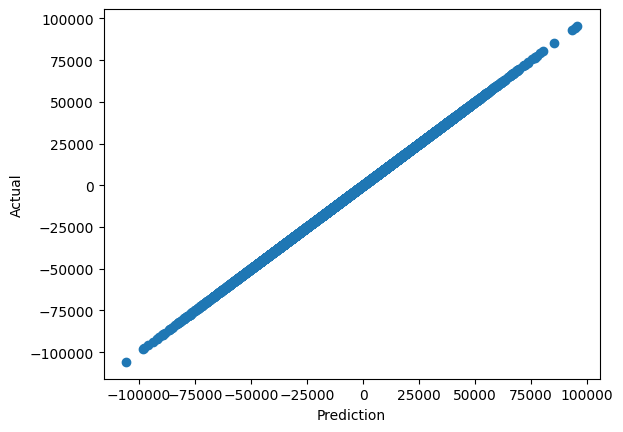

In [52]:
# What does the training accuracy look like?
plt.scatter(predictions, y)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [53]:
weights, new_predictions, _ = kernelpopper.get_quadratic_weights(model)

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 322.74it/s]


In [54]:
actual_cs=[]
popped_cs=[]
types=[]
weight_names=[]
# note the popped cs will be multiplied by the model's hyperparameters etc, so looking for relative magnitude and sign rather than exact match
for i in range(n_solo_features):
    popped_cs.append(weights[f'sqrt(2 * coef0 * gamma) * f{solo_features[i]}'])
    actual_cs.append(solo_weights[i])
    weight_names.append(f'f{solo_features[i]}')
    types.append(0)
for i in range(n_quad_features):
    actual_cs.append(quad_weights[i])
    if quad_features[i][0]==quad_features[i][1]:
        weight_name = f'f{quad_features[i][0]}**2 * gamma'
        types.append(1)
        weight_names.append(f'f{quad_features[i][0]}**2')
    else:
        if quad_features[i][0]>quad_features[i][1]:
            weight_name=f'sqrt(2) * f{quad_features[i][1]} * f{quad_features[i][0]} * gamma'
        else:
            weight_name=f'sqrt(2) * f{quad_features[i][0]} * f{quad_features[i][1]} * gamma'
        types.append(2)
        weight_names.append(f'f{quad_features[i][0]}*f{quad_features[i][1]}')
    popped_cs.append(weights[weight_name])

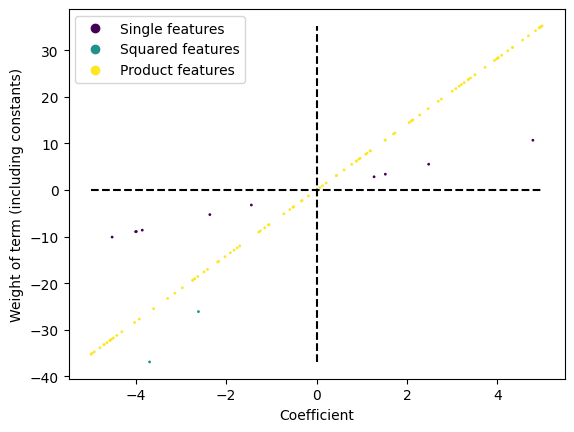

In [59]:
ax = plt.gca()
scatter = ax.scatter(actual_cs, popped_cs,s=1, c=types)
plt.plot([min(actual_cs),max(actual_cs)],[0,0], 'k--')
plt.plot([0,0], [min(popped_cs),max(popped_cs)], 'k--')
plt.xlabel('Coefficient')
plt.ylabel('Weight of term (including constants)')
handles, labels = scatter.legend_elements()
plt.legend(handles=handles, labels=['Single features', 'Squared features', 'Product features'])
plt.show()

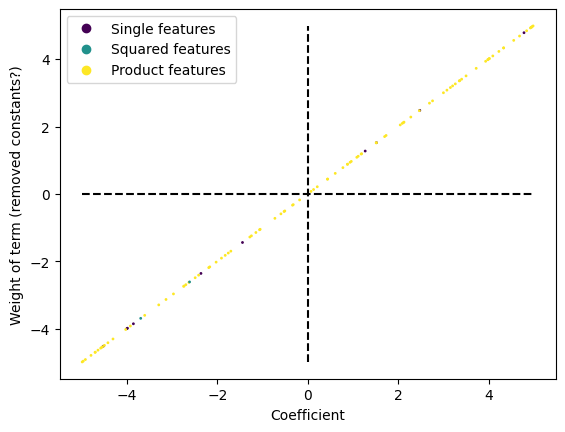

In [60]:
popped_cs_remove_constants=np.array(popped_cs.copy())
popped_cs_remove_constants[np.where(np.array(types)==0)]*=sqrt(2*model.coef0*model.gamma)
popped_cs_remove_constants[np.where(np.array(types)==1)]*=model.gamma
popped_cs_remove_constants[np.where(np.array(types)==2)]*=sqrt(2)*model.gamma

ax = plt.gca()
scatter = ax.scatter(actual_cs, popped_cs_remove_constants,s=1, c=types)
plt.plot([min(actual_cs),max(actual_cs)],[0,0], 'k--')
plt.plot([0,0], [min(popped_cs_remove_constants),max(popped_cs_remove_constants)], 'k--')
plt.xlabel('Coefficient')
plt.ylabel('Weight of term (removed constants?)')
handles, labels = scatter.legend_elements()
plt.legend(handles=handles, labels=['Single features', 'Squared features', 'Product features'])
plt.show()

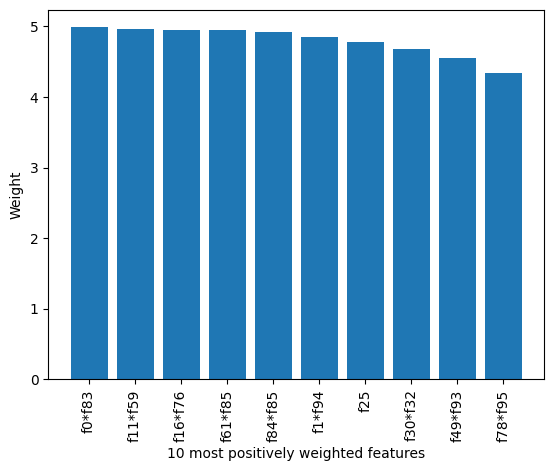

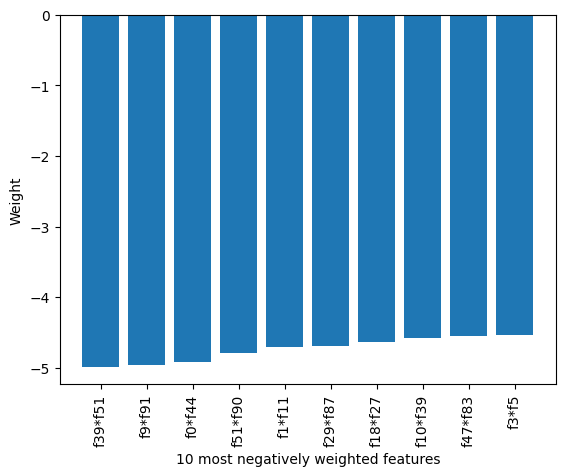

In [58]:
# investigate the top weights
n=10
indices=np.argsort(popped_cs_remove_constants)[::-1]
top_indices=indices[:n]
bottom_indices=indices[-n:][::-1]

plt.bar(range(n), popped_cs_remove_constants[top_indices])
plt.xticks(range(n), np.array(weight_names)[top_indices], rotation=90)
plt.xlabel(f'{n} most positively weighted features')
plt.ylabel('Weight')
plt.show()

plt.bar(range(n), popped_cs_remove_constants[bottom_indices])
plt.xticks(range(n), np.array(weight_names)[bottom_indices], rotation=90)
plt.xlabel(f'{n} most negatively weighted features')
plt.ylabel('Weight')
plt.show()